In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
train = pd.read_parquet('../data/04_model_input/train_gd')
cv = pd.read_parquet('../data/04_model_input/cv_gd')

In [4]:
X_train = train.iloc[:,1:].values
y_train = train['gender'].apply(lambda x: int(x=='M')).values
X_cv = cv.iloc[:,1:].values
y_cv = cv['gender'].apply(lambda x: int(x=='M')).values

In [5]:
test = pd.read_parquet('../data/04_model_input/test_gd')
X_test = test.iloc[:,1:].values
y_test = test['gender'].apply(lambda x: int(x=='M')).values

In [6]:
del train, cv, test

In [7]:
input_faces = keras.Input(shape = (X_train.shape[1]))
dense_1 = layers.Dense(70, activation='relu')(input_faces)
dropout_1 = layers.Dropout(0.3)(dense_1)
dense_2 = layers.Dense(50, activation='relu')(dropout_1)
dropout_2 = layers.Dropout(0.3)(dense_2)
dense_3 = layers.Dense(30, activation='relu')(dropout_2)
predictions = layers.Dense(1, activation='sigmoid')(dense_3)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [8]:
model = keras.Model(inputs=input_faces, outputs=predictions)

In [9]:

opt = keras.optimizers.Adam()

In [10]:
model.compile(
  opt,
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense (Dense)               (None, 70)                286790    
                                                                 
 dropout (Dropout)           (None, 70)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                3550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                1530      
                                                                 
 dense_3 (Dense)             (None, 1)                 31    

In [12]:
loss_train = []
loss_cv = []
acc_train = []
acc_cv = []

In [14]:
model_best = None
best_loss = np.inf
for i in range(30):
    model_fit = model.fit(
        x = X_train,
        y = y_train,
        validation_data=(X_cv, y_cv),
        use_multiprocessing=True,
        verbose=False,
    )
    loss_train += model_fit.history["loss"]
    loss_cv += model_fit.history["val_loss"]
    acc_train += model_fit.history['accuracy']
    acc_cv += model_fit.history['val_accuracy']
    if loss_cv[-1] < best_loss:
        best_loss = loss_cv[-1]
        model_best = keras.models.clone_model(model)
        model_best.build((None, X_train.shape[1]))
        model_best.compile(
            opt,
            loss='binary_crossentropy',
            metrics=['accuracy'],
        )
        model_best.set_weights(model.get_weights())

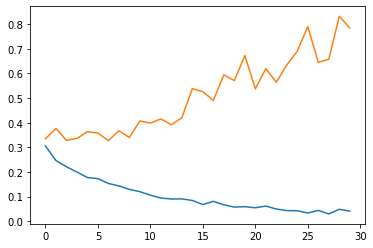

In [15]:
fig, ax = plt.subplots()
ax.plot(loss_train)
ax.plot(loss_cv)

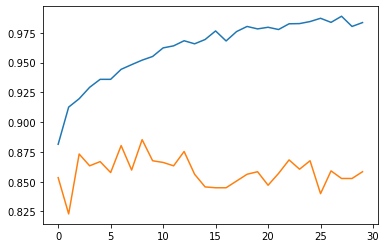

In [16]:
fig, ax = plt.subplots()
ax.plot(acc_train)
ax.plot(acc_cv)

In [17]:
test_pred = model_best.predict(X_test)

51/51 [==============================] - 0s 2ms/step


In [20]:
roc_auc_score(y_test, test_pred)

0.7807569568211807

In [21]:
accuracy_score(y_test,(test_pred>0.5).astype(int))

0.8534641324340895